# The double integrator example: the control loss case

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min T, \\[0.5em]
        \dot{x}_1(t) = x_2(t) \\
        \dot{x}_2(t) = u(t), \quad u(t) \in [-1, 1], \quad u \text{ constant over } \{x_1 < 0\},   \\[0.5em]
        x(0) = x_0,\quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$

In [1]:
using NLsolve
using Plots
using Plots.PlotMeasures
include("flow.jl");

In [2]:
# Parameters
t0  = 0.    # initial time
x1f = 0.    # Final position
x2f = 0.
M   = 1.0;  # control bound

In [3]:
# Dynamics
function F0(x)
    return [ x[2], 0.0 ]
end

function F1(x)
    return [ 0., 1. ]
end

# Hamiltonians: permanent region
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

Hc(x, p, u) = H0(x, p) + u*H1(x,p) # pseudo-Hamiltonian

up(x, p) =  M
um(x, p) = -M

Hp(x, p) = Hc(x, p, up(x, p))
Hm(x, p) = Hc(x, p, um(x, p))

# Hamiltonians: control loss region
Hnc(x, p, λ) = H0(x, p) + λ*H1(x,p) # pseudo-Hamiltonian

Hnc(X, P) = Hnc(X[1:2], P[1:2], X[3])

# Flows
fp  = Flow(Hp)
fm  = Flow(Hm)
fnc = Flow(Hnc);

In [4]:
# Shooting function
function shootBλBmBp(p0, λ, t1, t2, T, x0) # Bλ B- B+ structure
    
    #
    pλ0 = 0. # λ0 is free
    X1, P1 = fnc(t0, [x0; λ], [p0; pλ0], t1) # flow augmenté
    
    #
    ν = P1[2]*(-M-λ)/X1[2] # jump
    x2, p2 = fm(t1, X1[1:2], [P1[1]-ν, P1[2]], t2)

    #
    xT, pT = fp(t2, x2, p2, T)
    
    s = zeros(eltype(p0), 6)
    
    s[1:2] = xT - [ x1f, x2f ] # target
    
    s[3] = H1(x2, p2) # switching
    s[4] = Hp(xT, pT) - 1. # free final time
    
    s[5] = X1[1] # crossing
    s[6] = P1[3] # ∫ ∂H∂λ = 0 pris sur [t0, t1] 

    return s

end;

In [5]:
# Solve
x0 = [-1.; 0.]

S(ξ) = shootBλBmBp(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], x0)

λ0 = x0[2]^2/(2*x0[1])
λs = 1.0/(sqrt(2.)+1.) - sqrt(abs(λ0))/sqrt(1.0+sqrt(2.))
println(λs)

ξ_guess = [1, 1, λs, 2., 3., 4.] # initial guess

println("Initial value of shooting:\n", S(ξ_guess), "\n\n")

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    p0 = indirect_sol.zero[1:2]
    λ  = indirect_sol.zero[3]
    t1 = indirect_sol.zero[4]
    t2 = indirect_sol.zero[5]
    T  = indirect_sol.zero[6]
else
    error("Not converged")
end;

0.4142135623730951
Initial value of shooting:
[0.4852813742385703, 0.82842712474619, -0.29289321881345254, -1.1715728752538104, -0.17157287525380982, -3.699869201803029e-15]


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.171573e+00              NaN
     1     6.715668e+00     4.475452e-16
     2     4.644609e+00     0.000000e+00
     3     1.257044e+00     0.000000e+00
     4     5.098955e-01     5.095657e-01
     5     3.632823e-01     9.973552e-01
     6     2.208544e-01     1.009273e+00
     7     8.171029e-03     5.691074e-02
     8     1.174727e-05     2.836372e-03
     9     7.040191e-11     9.209879e-06
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 1.0, 0.4142135623730951, 2.0, 3.0, 4.0]
 * Zero: [2.19736822693623, 2.4142135623647616, 0.4142135623696492, 2.1973682269331527, 3.7511422009600954, 4.394736453864839]
 * Inf-norm of residuals: 0.000000
 * Iterations:

In [6]:
pλ0 = 0.
ode_sol = fnc((t0, t1), [x0; λ], [p0; pλ0], saveat=0.1)

tt1 = ode_sol.t
xx1 = [ ode_sol[1:2, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:5, j] for j in 1:size(tt1, 1) ]
uu1 = λ.*ones(length(tt1))

ν = ode_sol[5, end]*(-M-λ)/ode_sol[2, end] # jump
ode_sol = fm((t1, t2), xx1[end], pp1[end]+[ν, 0], saveat=0.1);


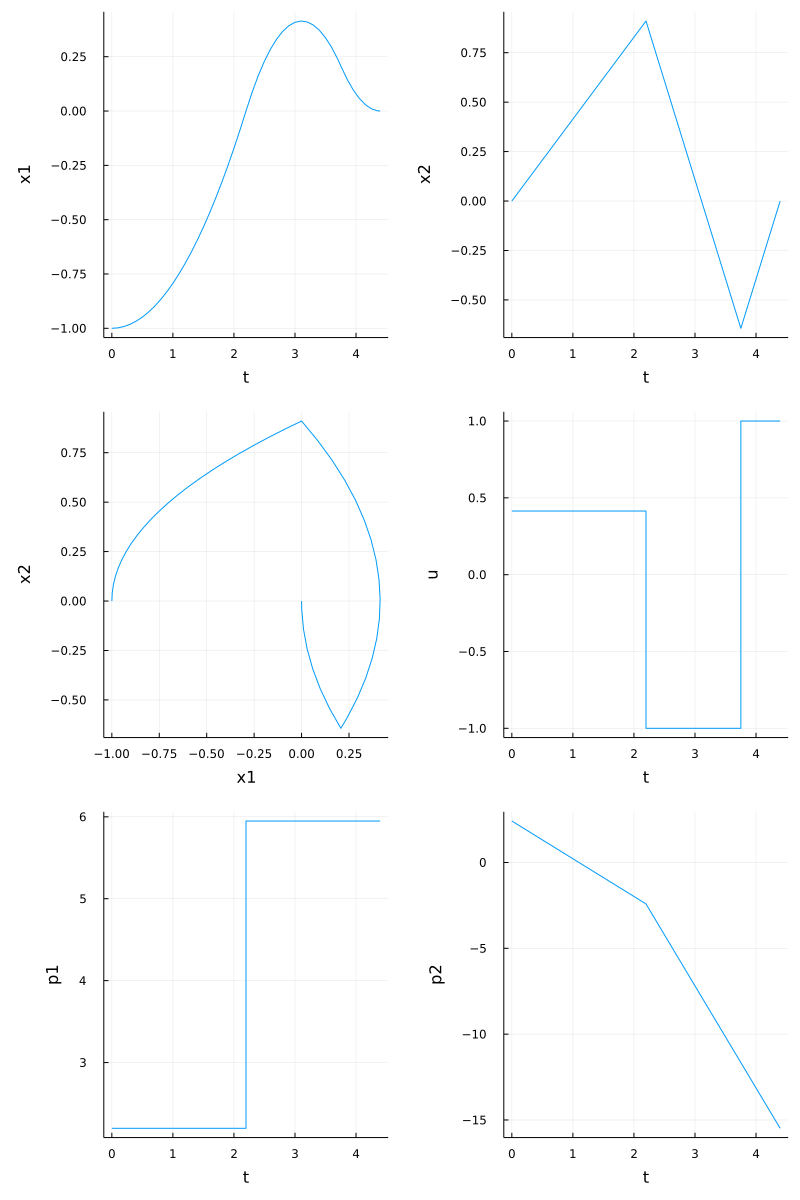

In [7]:
# plots

pλ0 = 0.
ode_sol = fnc((t0, t1), [x0; λ], [p0; pλ0], saveat=0.1)

tt1 = ode_sol.t
xx1 = [ ode_sol[1:2, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:5, j] for j in 1:size(tt1, 1) ]
uu1 = λ.*ones(length(tt1))

ν = ode_sol[5, end]*(-M-λ)/ode_sol[2, end] # jump
ode_sol = fm((t1, t2), xx1[end], pp1[end]+[ν, 0], saveat=0.1)

tt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[3:4, j] for j in 1:size(tt2, 1) ]
uu2 = um.(xx2, pp2)

ode_sol = fp((t2, T), xx2[end], pp2[end], saveat=0.1)

tt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(tt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(tt3, 1) ]
uu3 = up.(xx3, pp3)

t = [tt1; tt2; tt3]
x = [ xx1 ; xx2 ; xx3 ]
p = [ pp1 ; pp2 ; pp3 ]
u = [ uu1 ; uu2 ; uu3 ]

m = length(t)
x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot, p2_plot, layout = (3,2), size=(800,1200), left_margin=10mm)